In [50]:
import pandas as pd
import numpy as np


In [51]:
filepath = "train.csv"
df = pd.read_csv(filepath)

Drop FireplaceQu, PoolQC, Fence, MiscFeature, Alley

In [4]:
# old version
df = df.drop(['Alley'],axis=1)
df = df.drop(['PoolQC'],axis=1)
df = df.drop(['Fence'],axis=1)
df = df.drop(['FireplaceQu'],axis=1)

In [83]:
# new version
df = df.drop(['PoolQC'],axis=1)
df = df.drop(['FireplaceQu'],axis=1)
df = df.drop(['MiscFeature'],axis=1)

In [55]:
if (df.iloc[:,5].dtype == 'O'):
    print("yes")

df['Alley']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      1
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
1430    0
1431    0
1432    1
1433    0
1434    0
1435    0
1436    0
1437    0
1438    0
1439    0
1440    0
1441    0
1442    0
1443    0
1444    0
1445    0
1446    0
1447    0
1448    0
1449    0
1450    0
1451    0
1452    0
1453    0
1454    2
1455    0
1456    0
1457    0
1458    0
1459    0
Name: Alley, Length: 1460, dtype: int64

Label encoding

In [53]:
#more intelligent label encoding and NA-filling for 81 columns
for i in range(0,81):
    if (df.iloc[:,i].dtype == 'O'):
        df.iloc[:,i] = df.iloc[:,i].fillna("0")
    else:
        df.iloc[:,i] = df.iloc[:,i].fillna(df.iloc[:,i].mean())

df['Alley']
    

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21      Grvl
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
        ... 
1430       0
1431       0
1432    Grvl
1433       0
1434       0
1435       0
1436       0
1437       0
1438       0
1439       0
1440       0
1441       0
1442       0
1443       0
1444       0
1445       0
1446       0
1447       0
1448       0
1449       0
1450       0
1451       0
1452       0
1453       0
1454    Pave
1455       0
1456       0
1457       0
1458       0
1459       0
Name: Alley, Length: 1460, dtype: object

In [47]:
df = df.fillna(df.mean())
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [5]:
!pip install xgboost

mkl-random 1.0.1 requires cython, which is not installed.
tensorflow 1.11.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.4.3 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [54]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df = df.apply(preprocessing.LabelEncoder().fit_transform)


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
y = df['SalePrice']
X = df.drop(['SalePrice'],axis=1)
train_X, test_X, train_y, test_y = train_test_split(X.values,y.values, test_size=.2)

In [57]:
import xgboost as xgb
my_model= xgb.XGBRegressor(n_estimators=3000, learning_rate=0.025)

In [58]:
my_model.fit(train_X, train_y, early_stopping_rounds=500, eval_set=[(test_X, test_y)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.025, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [82]:
# make predictions to evaluate
# standard, no tuning -> 35.98 & 2334.3
# n_est = 1000, early_stopping_round = 5 -> 35.6 & 2290.3
# n_est = 1000, early_stopping_round = 5, learning_rate = 0.05 -> 35.3 & 2235.4
# n_est = 1000, early_stopping_round = 5, learning_rate = 0.05 (drop new version) -> 34.1 & 2148.0
# n_est = 2000, early_stopping_round = 100, learning_rate = 0.05 (drop new version) -> 32.8 & 2074.1
# n_est = 2000, early_stopping_round = 300, learning_rate = 0.03 (drop new version) -> 34.0 & 1901.4
# n_est = 2000, early_stopping_round = 500, learning_rate = 0.025 (drop new version) -> 33.4 & 1848.9
predictions = my_model.predict(test_X)
# mean absolute error
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error : ' + str(mean_absolute_error(predictions, test_y)))
# mean squared error
from sklearn.metrics import mean_squared_error
print('Mean Squared Error: ' + str(mean_squared_error(predictions, test_y)))

Mean Absolute Error : 31.647270995460143
Mean Squared Error: 1987.8761603999205


In [83]:
#testing where the largest error is
err_marg = 5
for i in range (0,292):
    if (abs((test_y[i] - predictions[i])/test_y[i])>err_marg):
        print(i)


101
285


In [84]:
print("test is",test_y[62]," and prediction ",predictions[62])
abs(test_y[62] - predictions[62])>180


test is 82  and prediction  128.8132


False

In [93]:
# Outlier analysis - we seem to have one item in our test data at index "101" which corresponds to Id = 916 in initial df
# This post has a sale price that was 1000 USD....
test_X[101]
df.iloc[916,:] - df.iloc[917,:]

Id                -1
MSSubClass         0
MSZoning          -3
LotFrontage      -21
LotArea         -589
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       2
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual       -2
OverallCond       -3
YearBuilt         -7
YearRemodAdd      -6
RoofStyle          0
RoofMatl           0
Exterior1st      -12
Exterior2nd      -13
MasVnrType         0
MasVnrArea         0
ExterQual          0
ExterCond          0
Foundation         0
                ... 
BedroomAbvGr      -2
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd      -2
Functional         0
Fireplaces         0
FireplaceQu        0
GarageType         4
GarageYrBlt        2
GarageFinish       1
GarageCars         0
GarageArea        16
GarageQual         0
GarageCond         0
PavedDrive         0
WoodDeckSF         0
OpenPorchSF  

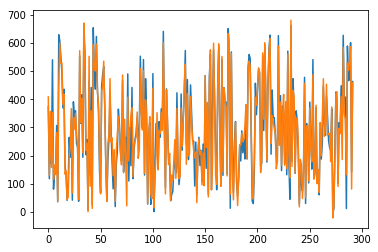

In [63]:
import matplotlib.pyplot  as plt
plt.plot(test_y)
plt.plot(predictions)
plt.show()

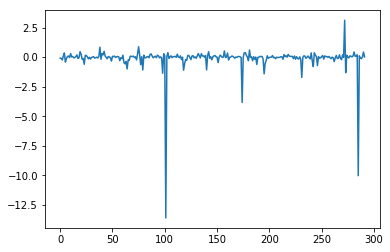

In [64]:
plt.plot((test_y - predictions)/test_y)
plt.show()

In [80]:
# START PREDICTING THE COMPETITION DATA
testFile = "test.csv"

test_data = pd.read_csv(testFile)
test_data['Id']

0       1461
1       1462
2       1463
3       1464
4       1465
5       1466
6       1467
7       1468
8       1469
9       1470
10      1471
11      1472
12      1473
13      1474
14      1475
15      1476
16      1477
17      1478
18      1479
19      1480
20      1481
21      1482
22      1483
23      1484
24      1485
25      1486
26      1487
27      1488
28      1489
29      1490
        ... 
1429    2890
1430    2891
1431    2892
1432    2893
1433    2894
1434    2895
1435    2896
1436    2897
1437    2898
1438    2899
1439    2900
1440    2901
1441    2902
1442    2903
1443    2904
1444    2905
1445    2906
1446    2907
1447    2908
1448    2909
1449    2910
1450    2911
1451    2912
1452    2913
1453    2914
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64

In [142]:
# Manipulate the data by dropping unwanted columns (we will not drop columns in the new way of handling the dataa)
test_data = test_data.drop(['PoolQC'],axis=1)
test_data = test_data.drop(['FireplaceQu'],axis=1)
test_data = test_data.drop(['MiscFeature'],axis=1)

In [72]:
test_data = test_data.reindex(X.columns, axis=1)

In [76]:
# More intelligent label encoding and NA-filling
for i in range(0,80):
    if (test_data.iloc[:,i].dtype == 'O'):
        test_data.iloc[:,i] = test_data.iloc[:,i].fillna("0")
    else:
        test_data.iloc[:,i] = test_data.iloc[:,i].fillna(test_data.iloc[:,i].mean())

test_data = test_data.apply(preprocessing.LabelEncoder().fit_transform)

In [144]:
# OLD OLD OLD Labelencode the data that is missing

test_data = test_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
test_data = test_data.apply(preprocessing.LabelEncoder().fit_transform)

In [77]:
test_data.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,0,3,57,777,1,0,3,3,1,...,18,0,0,3,0,0,5,4,9,4


In [78]:
# Make competition prediction
test_preds = my_model.predict(test_data.values)

In [81]:
# Save prediction to competition submission file
output = pd.DataFrame({'Id': test_data['Id'],
                       'SalePrice': test_preds*1000})

output.to_csv('submission.csv', index=False)